In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import cv2

import torch
import torch.nn as nn


from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

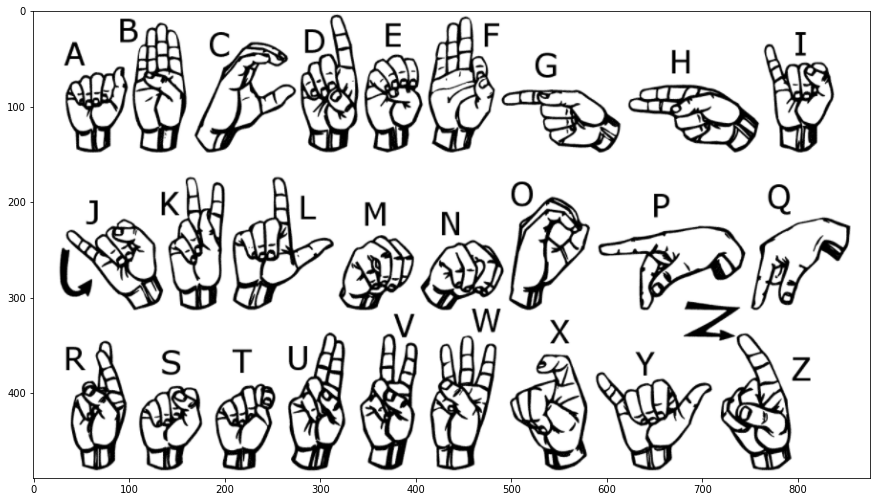

In [3]:

img_path = ["/kaggle/input/sign-language-mnist/american_sign_language.PNG",
            "/kaggle/input/sign-language-mnist/amer_sign3.png",
            "/kaggle/input/sign-language-mnist/amer_sign2.png"]
img = cv2.imread(img_path[0], cv2.IMREAD_COLOR)
plt.figure(figsize=(15,15))
plt.imshow(img)


In [4]:
# Load data
train_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


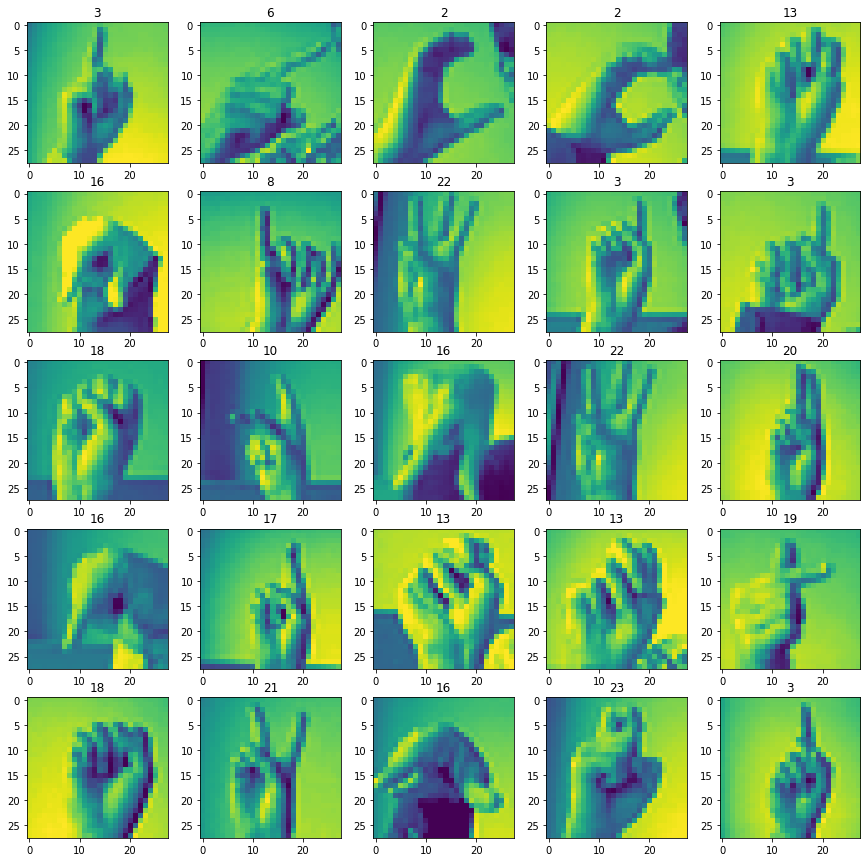

In [5]:
# Examples of images

plt.figure(figsize=(15,15))
for i in range(25):
    img = np.array(train_df.iloc[i, 1:].values).reshape(28,28)

    plt.subplot(5,5, i+1)
    plt.imshow(img)
    plt.title(train_df.iloc[i, 0])

In [6]:
# Small EDA
num_classes = len(train_df.label.unique())
print("Unique labels:", len(train_df.label.unique()))
train_df['label'].value_counts()

Unique labels: 24


17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [7]:
# class for load data

class MNIST_Dataset(Dataset):
    
    def __init__(self, dataset, transforms = None):
        
        super().__init__()
        
        self.dataset = dataset
        self.transforms = transforms
        
        
    def __getitem__(self, index):
        
        #Reading image
        item = np.array(self.dataset.iloc[index, 1:].values).reshape(28,28) / 255
        item = torch.from_numpy(item).to(torch.float32)
        item = torch.unsqueeze(item, 0)
        
        label = np.array(self.dataset.iloc[index, 0])
        label = torch.from_numpy(label)
        
        if self.transforms:
            item = self.transforms(item)
            
        return item, label
        
        
    def __len__(self):
        return self.dataset.shape[0]

In [8]:
transform_augmentation = T.Compose([
#     T.RandomCrop((28, 28)),
#     transforms.RandomHorizontalFlip(p=0.5),
     T.RandomRotation(degrees=(-20, 20)),
#     transforms.RandomVerticalFlip(p=0.5),
     ])

In [9]:
train_dataset = MNIST_Dataset(train_df, transform_augmentation)
test_dataset = MNIST_Dataset(test_df)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    shuffle=True,
    #sampler = train_random_sampler,
    num_workers = 2,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    shuffle=False,
    #sampler = valid_random_sampler,
    num_workers = 2,
)

In [10]:
sample = next(iter(train_data_loader))
sample[0][0].shape

torch.Size([1, 28, 28])

In [11]:
class ConvSoftmaxClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Initialize layer
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding='same'),  # 28x28x1 -> 28x28x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 28x28x8 -> 14x14x8
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding='same'),  #14x14x8 -> 14x14x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 14x14x16-> 7x7x16
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same'),  # 7x7x16 -> 7x7x32
            nn.ReLU(),
            
            nn.Flatten(), #  7x7x32 -> 1568
            nn.Linear(7*7*32, 800),

            nn.ReLU(),
            nn.Linear(800, num_classes),     
        )
        self.activation = nn.Softmax(dim=1)

    # Required: overrides __call__
    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return self.activation(self(x))

    def predict(self, x):
        return torch.argmax(self.activation(self(x)), dim=1)

classifier = ConvSoftmaxClassifier(num_classes+1)

#classifier.to(device)

In [12]:
loss = nn.CrossEntropyLoss()

# Gradient descent update rule
optimizer = torch.optim.SGD(classifier.parameters(), # Put parameters to optimize here 
                            lr=1e-2, # Learning rate
                            weight_decay=1e-5 # Put L2 regularization here
            )

In [13]:
n_epochs = 15

train_history = []
valid_history = []

for i in range(n_epochs):
    # Iterate over batches

    classifier.train()
    epoch_loss = 0
    iter_loss = 0
    for j, (x, y) in enumerate(train_data_loader):
        # Forward
        #x = x.to(device)
        #y = y.to(device)
        y_hat = classifier(x)

        # Compute loss
        loss_batch = loss(y_hat, y)
        
        epoch_loss += loss_batch.item()
        
        iter_loss += loss_batch.item()
        
        if (j > 0) and (j % 300 == 0):
            print("Iter # {}, loss = {:3}".format(j, iter_loss))
            iter_loss = 0
        
        #pbar.set_postfix({'loss_batch': float(loss_batch.item())})

        optimizer.zero_grad() # Do not forget this!
        # Backward: propagate gradients
        loss_batch.backward()
        
        # Update
        optimizer.step()
    
    # Validation    
    with torch.no_grad():
        classifier.eval() # Equivalent: classifier.eval()

        valid_loss = 0
        for x, y in test_data_loader:
            y_hat = classifier(x)
            loss_batch = loss(y_hat, y)            
            valid_loss += loss_batch.item()
    
    train_history.append(epoch_loss)
    valid_history.append(valid_loss)
    
    print("Epoch #{}, Train loss = {:3}, Valid loss = {:3}".format(i, epoch_loss, valid_loss))

Iter # 300, loss = 967.1372635364532
Iter # 600, loss = 958.9642262458801
Iter # 900, loss = 955.0249967575073
Iter # 1200, loss = 953.2906062602997
Iter # 1500, loss = 949.9479684829712
Epoch #0, Train loss = 5462.435526847839, Valid loss = 1409.1736466884613
Iter # 300, loss = 930.8761956691742
Iter # 600, loss = 851.0650951862335
Iter # 900, loss = 725.226310133934
Iter # 1200, loss = 602.0837898254395
Iter # 1500, loss = 531.8608808517456
Epoch #1, Train loss = 3984.0603541731834, Valid loss = 638.6990111470222
Iter # 300, loss = 425.33422297239304
Iter # 600, loss = 374.8474023938179
Iter # 900, loss = 337.29260817170143
Iter # 1200, loss = 305.10189029574394
Iter # 1500, loss = 270.7702105939388
Epoch #2, Train loss = 1889.0097203403711, Valid loss = 488.3920044898987
Iter # 300, loss = 218.91620840877295
Iter # 600, loss = 197.50138315558434
Iter # 900, loss = 182.5584602355957
Iter # 1200, loss = 157.9774252474308
Iter # 1500, loss = 146.17235739529133
Epoch #3, Train loss = 99

Text(0.5, 1.0, 'Valid Loss')

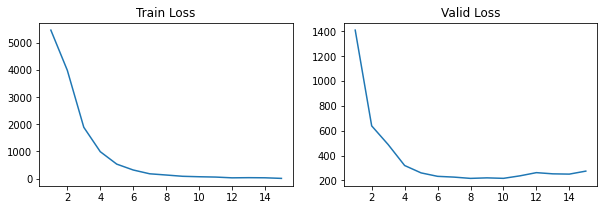

In [14]:
#Train history

idx = [i for i in range(1,len(train_history)+1)]

plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(idx, train_history)
plt.title("Train Loss")


plt.subplot(1, 2, 2)
plt.plot(idx, valid_history)
plt.title("Valid Loss")

In [15]:
with torch.no_grad():
    #classifier.cuda()
    classifier.eval() # Equivalent: classifier.eval()

    test_preds = []
    test_labels = []
    for x, y in test_data_loader:
        #x = x.cuda()
        #y = y.cuda()
        test_labels += list(y)#.cpu())
        #pred = classifier.predict(x)
        
        test_preds += list(classifier.predict(x))#.cpu())

print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       331
           1       1.00      1.00      1.00       432
           2       0.93      1.00      0.97       310
           3       0.87      1.00      0.93       245
           4       0.92      0.94      0.93       498
           5       0.91      0.98      0.94       247
           6       0.98      0.89      0.93       348
           7       1.00      1.00      1.00       436
           8       0.83      0.94      0.88       288
          10       0.90      0.76      0.82       331
          11       0.98      1.00      0.99       209
          12       0.86      0.80      0.83       394
          13       0.84      0.69      0.76       291
          14       1.00      0.81      0.90       246
          15       1.00      0.95      0.97       347
          16       0.71      0.99      0.83       164
          17       0.55      0.83      0.66       144
          18       0.85    

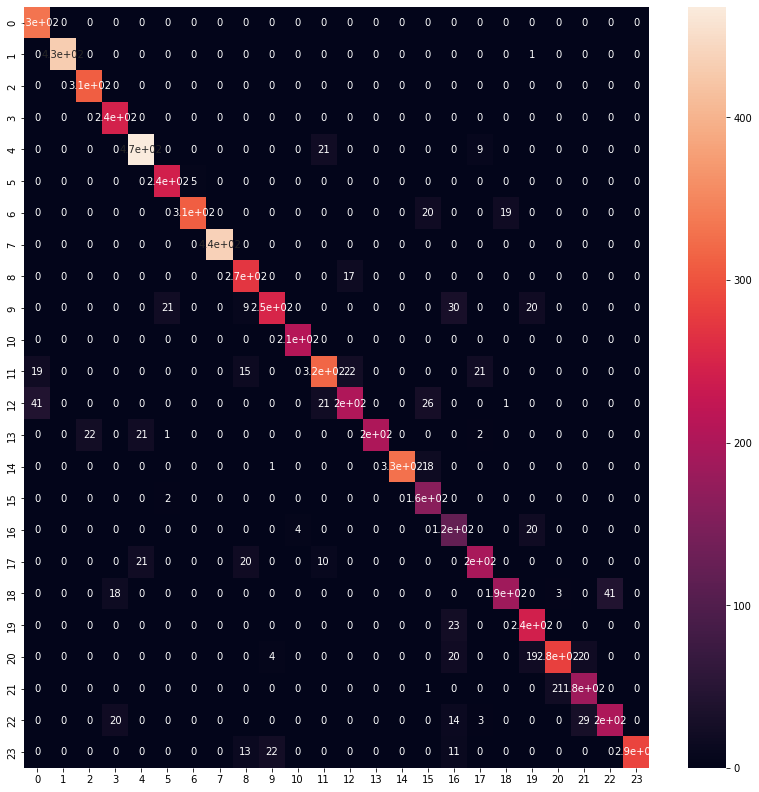

In [16]:
# Confusion matrix

plt.figure(figsize=(14,14))
cm = confusion_matrix(test_labels, test_preds)#, labels=clf.classes_)
sns.heatmap(cm, annot=True)
plt.show()

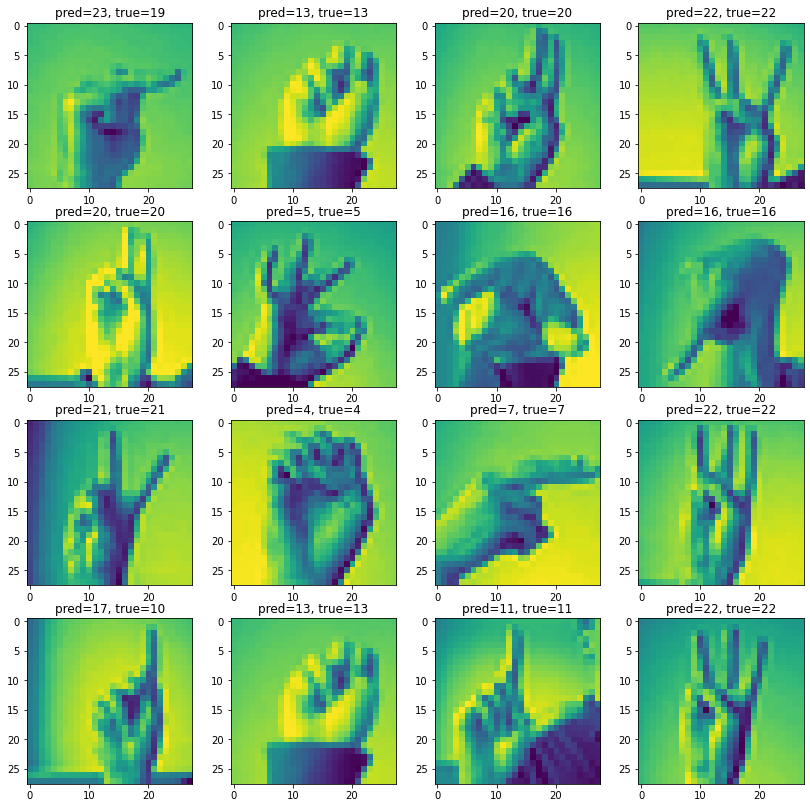

In [17]:
# Examples of predictions with images
skip = 3
for x, y in test_data_loader:
    if (skip > 0):
        skip -= 1
        continue
    preds = list(classifier.predict(x))
    break

plt.figure(figsize=(14,14))
for i in range(16):
    img = np.array(train_df.iloc[i, 1:].values).reshape(28,28)

    plt.subplot(4,4, i+1)
    plt.imshow(x[i].squeeze().detach().numpy())
    plt.title("pred={}, true={}".format(preds[i],y[i]))

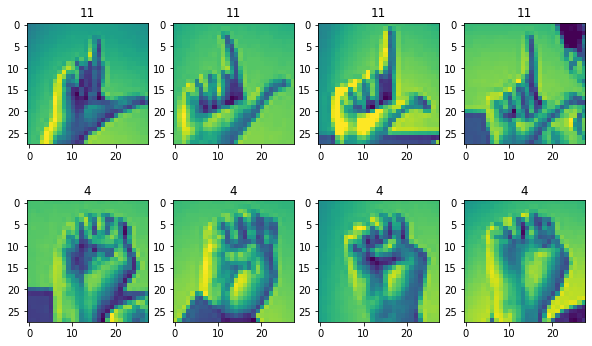

In [18]:
# Examples of the most confused labels  (11, 4)

a = train_df[train_df["label"] == 11].sample(4)
b = train_df[train_df["label"] == 4].sample(4)

plt.figure(figsize=(10,6))
for i in range(4):
    img = np.array(a.iloc[i, 1:].values).reshape(28,28)
    plt.subplot(2,4, i+1)
    plt.imshow(img)
    plt.title(a.iloc[i, 0])

for i in range(4):
    img = np.array(b.iloc[i, 1:].values).reshape(28,28)
    plt.subplot(2,4, i+1+4)
    plt.imshow(img)
    plt.title(b.iloc[i, 0])